This notebook analyses quantizer weights collected from rav1e test set encodes and derives linear models for computing 6 inter-frame quantizers from the API quantizer.

The weights are defined in terms of eq. 20 in [av1-metric.pdf]:
$$
\bar Q = \sqrt{\frac{\sum_i N_i \sigma_i^2}{\sum_i \frac{N_i \sigma_i^2}{Q_i^2}}},
$$
or:
$$
{\bar Q}^2 = \frac1{\frac{\sum_i \frac{N_i \sigma_i^2}{Q_i^2}}{\sum_i N_i \sigma_i^2}}
 = \frac1{\sum_i \frac{\frac{N_i \sigma_i^2}{Q_i^2}}{\sum_j N_j \sigma_j^2}}
 = \frac1{\sum_i \left(\frac{N_i \sigma_i^2}{\sum_j N_j \sigma_j^2} \frac1{Q_i^2}\right)}.
$$

Here, $i$ and $j$ go across 6 quantizer types $\left\{\text{Y}, \text{Cb}, \text{Cr}\right\}\times\left\{\text{AC}, \text{DC}\right\}$.

The term "weights" or "relative weights" refers to the $\frac{N_i \sigma_i^2}{\sum_j N_j \sigma_j^2}$ factors.

Knowing $\bar Q$ (for example, it could be derived directly from the API quantizer) and the weights (collected from test encodes), we would like to find 6 quantizers on the right hand side of the equation, such that the equation holds.

The weights are collected in the following fashion:
1. Test sequences are encoded at every API quantization index in $\left[1, 239\right]$ with temporal RDO disabled and using the following settings: `--low-latency --tune=psnr --rdo-lookahead-frames=1 --quantizer={q}`. For each frame the encoder picks a set of 6 quantizer indices. Using the vstats data, `process-vstats` computes $N_i$ and $\sigma_i^2$ for each quantizer type, then converts those into six weight samples for each frame. All of these weight samples are saved into a JSON file for each test sequence.
1. This notebook reads the JSON files and averages collected weight samples for each quantizer index.

[av1-metric.pdf]: http://dgql.org/~derf/av1-metric.pdf

To run this notebook, you will need:
1. Python 3.7 or above.
1. NumPy, matplotlib, scikit-learn, tqdm.
1. Output from the [rav1e data collection branch](https://github.com/xiph/rav1e/tree/quantizer-weight-data-collection) ran as follows:

    ```sh
    for q in $(seq 1 239); do
        rav1e \
            --threads=1 \
            --low-latency \
            --tune=psnr \
            --rdo-lookahead-frames=1 \
            --quantizer $q \
            -o /dev/null \
            /path/to/videos/old_town_cross_420_720p50.y4m \
            >old_town_cross_420_720p50-q$q.log \
            2>/dev/null
    done
    ```
    
    I've run it across 4:2:0, 4:2:2 and 4:4:4 versions of ducks_take_off, in_to_tree, old_town_cross and park_joy. The data for this notebook was obtained on commit [d80eb15599aeb58c99bbfe36db7d66bbd7429bff](https://github.com/xiph/rav1e/commit/d80eb15599aeb58c99bbfe36db7d66bbd7429bff).
1. Output from `tools/process-vstats` from the same branch, ran over the log files produced in the previous steps.

In [1]:
import json
from os import listdir
from os.path import join

from matplotlib import pyplot as plt
import numpy as np
from sklearn import linear_model
from tqdm import tqdm
%matplotlib inline

Define the quantizer tables.

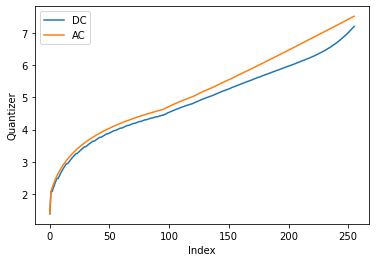

In [2]:
DC_LOOKUP_Q3 = np.array([
    4,    8,    8,    9,    10,  11,  12,  12,  13,  14,  15,   16,   17,   18,
    19,   19,   20,   21,   22,  23,  24,  25,  26,  26,  27,   28,   29,   30,
    31,   32,   32,   33,   34,  35,  36,  37,  38,  38,  39,   40,   41,   42,
    43,   43,   44,   45,   46,  47,  48,  48,  49,  50,  51,   52,   53,   53,
    54,   55,   56,   57,   57,  58,  59,  60,  61,  62,  62,   63,   64,   65,
    66,   66,   67,   68,   69,  70,  70,  71,  72,  73,  74,   74,   75,   76,
    77,   78,   78,   79,   80,  81,  81,  82,  83,  84,  85,   85,   87,   88,
    90,   92,   93,   95,   96,  98,  99,  101, 102, 104, 105,  107,  108,  110,
    111,  113,  114,  116,  117, 118, 120, 121, 123, 125, 127,  129,  131,  134,
    136,  138,  140,  142,  144, 146, 148, 150, 152, 154, 156,  158,  161,  164,
    166,  169,  172,  174,  177, 180, 182, 185, 187, 190, 192,  195,  199,  202,
    205,  208,  211,  214,  217, 220, 223, 226, 230, 233, 237,  240,  243,  247,
    250,  253,  257,  261,  265, 269, 272, 276, 280, 284, 288,  292,  296,  300,
    304,  309,  313,  317,  322, 326, 330, 335, 340, 344, 349,  354,  359,  364,
    369,  374,  379,  384,  389, 395, 400, 406, 411, 417, 423,  429,  435,  441,
    447,  454,  461,  467,  475, 482, 489, 497, 505, 513, 522,  530,  539,  549,
    559,  569,  579,  590,  602, 614, 626, 640, 654, 668, 684,  700,  717,  736,
    755,  775,  796,  819,  843, 869, 896, 925, 955, 988, 1022, 1058, 1098, 1139,
    1184, 1232, 1282, 1336,
])
AC_LOOKUP_Q3 = np.array([
    4,    8,    9,    10,   11,   12,   13,   14,   15,   16,   17,   18,   19,
    20,   21,   22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
    33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,   44,   45,
    46,   47,   48,   49,   50,   51,   52,   53,   54,   55,   56,   57,   58,
    59,   60,   61,   62,   63,   64,   65,   66,   67,   68,   69,   70,   71,
    72,   73,   74,   75,   76,   77,   78,   79,   80,   81,   82,   83,   84,
    85,   86,   87,   88,   89,   90,   91,   92,   93,   94,   95,   96,   97,
    98,   99,   100,  101,  102,  104,  106,  108,  110,  112,  114,  116,  118,
    120,  122,  124,  126,  128,  130,  132,  134,  136,  138,  140,  142,  144,
    146,  148,  150,  152,  155,  158,  161,  164,  167,  170,  173,  176,  179,
    182,  185,  188,  191,  194,  197,  200,  203,  207,  211,  215,  219,  223,
    227,  231,  235,  239,  243,  247,  251,  255,  260,  265,  270,  275,  280,
    285,  290,  295,  300,  305,  311,  317,  323,  329,  335,  341,  347,  353,
    359,  366,  373,  380,  387,  394,  401,  408,  416,  424,  432,  440,  448,
    456,  465,  474,  483,  492,  501,  510,  520,  530,  540,  550,  560,  571,
    582,  593,  604,  615,  627,  639,  651,  663,  676,  689,  702,  715,  729,
    743,  757,  771,  786,  801,  816,  832,  848,  864,  881,  898,  915,  933,
    951,  969,  988,  1007, 1026, 1046, 1066, 1087, 1108, 1129, 1151, 1173, 1196,
    1219, 1243, 1267, 1292, 1317, 1343, 1369, 1396, 1423, 1451, 1479, 1508, 1537,
    1567, 1597, 1628, 1660, 1692, 1725, 1759, 1793, 1828,
])

plt.plot(np.arange(256), np.log(DC_LOOKUP_Q3[np.arange(256)]), label='DC')
plt.plot(np.arange(256), np.log(AC_LOOKUP_Q3[np.arange(256)]), label='AC')
plt.xlabel('Index')
plt.ylabel('Quantizer')
plt.legend()
plt.show()

Set up some constants.

In [3]:
# Path to the same directory as --output-dir in process-vstats.
OUTPUT_DIR = 'process-vstats/out'
# Path to the same directory as --data-dir in process-vstats.
DATA_DIR = 'vstats'

# Filenames are assumed to be in the form of {sequence}_{subsampling}_720p50.json
SEQUENCES = ['ducks_take_off', 'in_to_tree', 'old_town_cross', 'park_joy']
SUBSAMPLINGS = ['420', '422', '444']

PLANES = list(range(3))
Q_TYPES = ['dc', 'ac']

PLANE_NAMES = {
    0: 'Y',
    1: 'Cb',
    2: 'Cr',
}

Q_TYPE_TO_LOOKUP = {
    'dc': DC_LOOKUP_Q3,
    'ac': AC_LOOKUP_Q3,
}

# Inter

First accumulate average weights per-sequence (so each JSON file is read only once), then average them across sequences.

Note that code below depends on dict insertion order being preserved (which is official starting from Python 3.7).

In [4]:
mean_data_per_seq = {
    sequence: {
        subsampling: {
            plane: {
                q_type: {} for q_type in Q_TYPES
            } for plane in PLANES
        } for subsampling in SUBSAMPLINGS
    } for sequence in SEQUENCES
}

for sequence in tqdm(SEQUENCES):
    for subsampling in SUBSAMPLINGS:
        with open(join(OUTPUT_DIR, f'{sequence}_{subsampling}_720p50.json'), 'r') as f:
            data = json.load(f)

        for plane in PLANES:
            for q_type in Q_TYPES:
                for qidx in range(256):
                    values = data['false'][str(plane)][f'{q_type}_weights'][qidx]
                    if len(values) != 0:
                        mean_data_per_seq[sequence][subsampling][plane][q_type][qidx] = np.mean(values)

mean_data = {
    subsampling: {
        plane: {
            q_type: {} for q_type in Q_TYPES
        } for plane in PLANES
    } for subsampling in SUBSAMPLINGS
}

for subsampling in tqdm(SUBSAMPLINGS):
    for plane in PLANES:
        for q_type in Q_TYPES:
            for qidx in range(256):
                values = []
                for sequence in SEQUENCES:
                    data = mean_data_per_seq[sequence][subsampling][plane][q_type]
                    if qidx in data:
                        values.append(data[qidx])

                if len(values) > 0:
                    mean_data[subsampling][plane][q_type][qidx] = np.mean(values)

100%|██████████| 3/3 [00:00<00:00, 39.27it/s]


Plots of the relative weights of the Inter Y AC quantizers for different subsamplings.

Note that while it stays somewhat constant in 4:2:0, it changes quite a bit for 4:2:2 and 4:4:4.

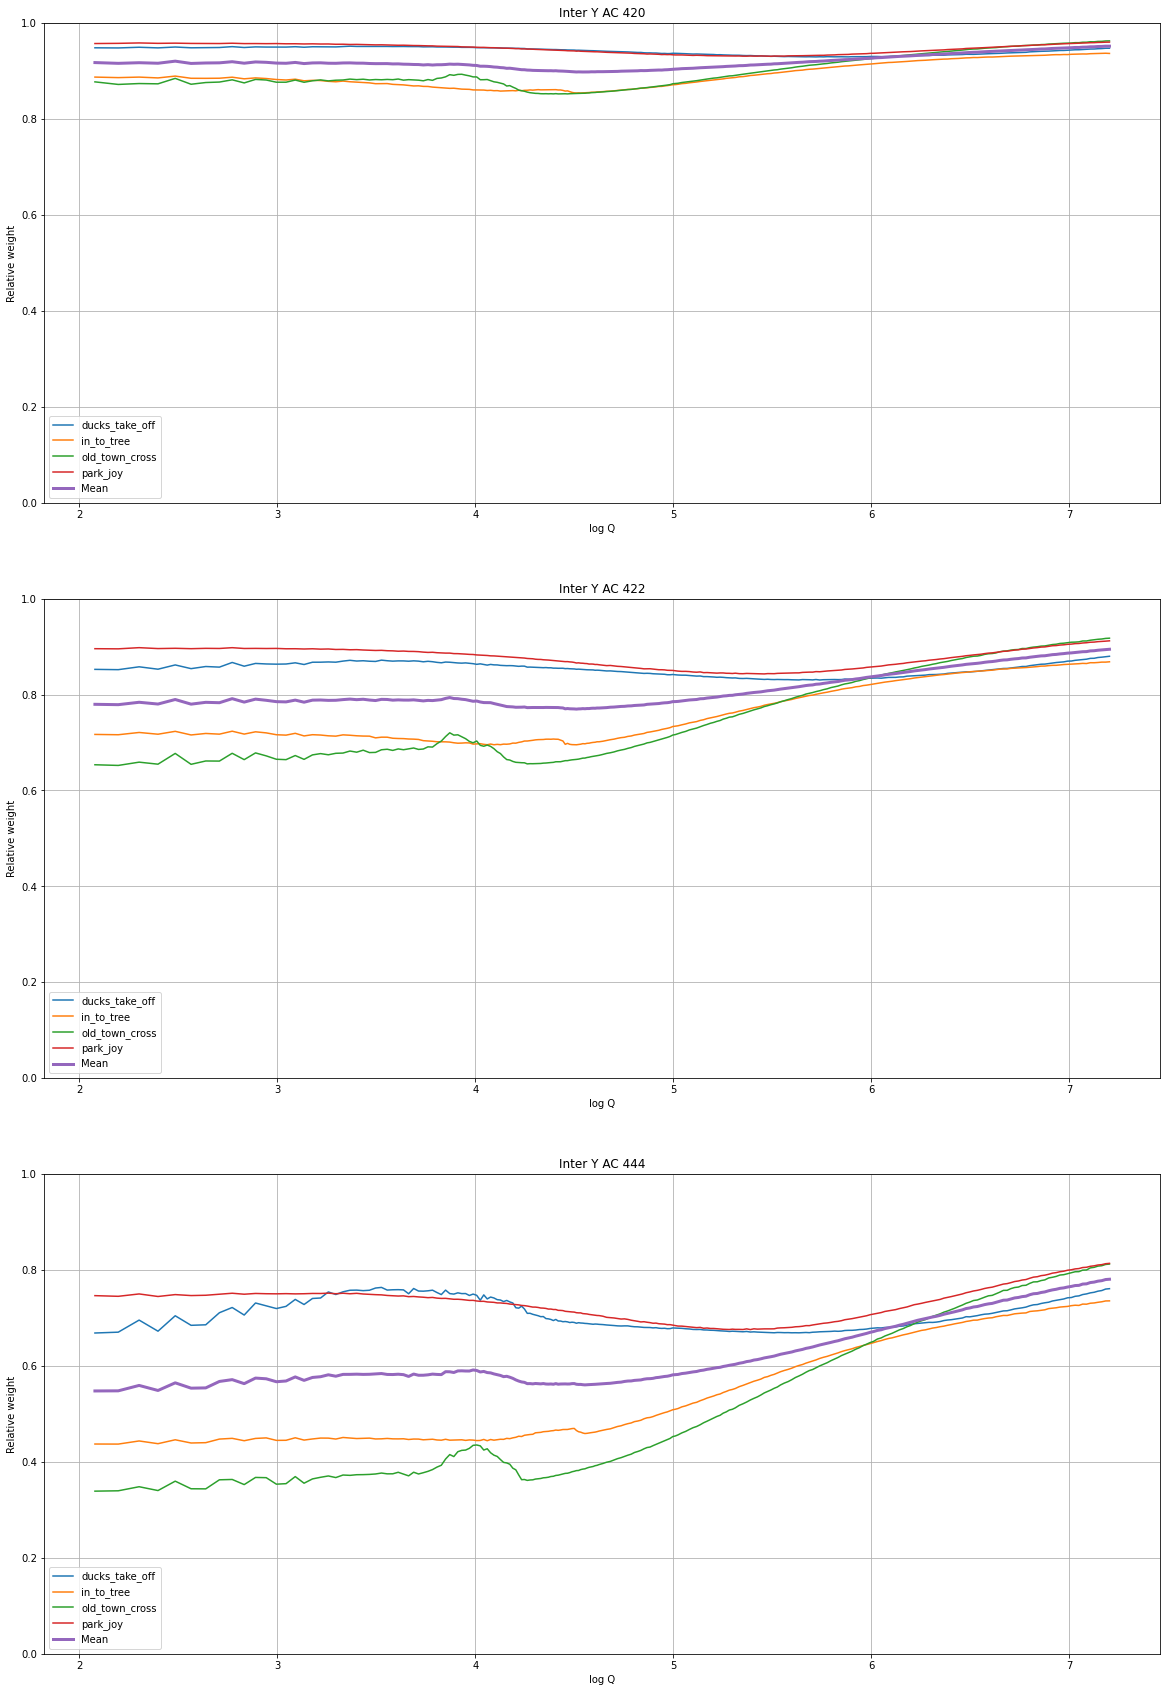

In [5]:
plt.figure(figsize=(20, 30))
    
for n, subsampling in enumerate(SUBSAMPLINGS):
    plt.subplot(3, 1, n + 1)

    for sequence in SEQUENCES:
        data = mean_data_per_seq[sequence][subsampling][0]['ac']
        qidxs, values = list(data.keys()), list(data.values())
        plt.plot(np.log(AC_LOOKUP_Q3[qidxs]), values, label=sequence)
        
    data = mean_data[subsampling][0]['ac']
    qidxs, values = list(data.keys()), list(data.values())
    plt.plot(np.log(AC_LOOKUP_Q3[qidxs]), values, label='Mean', linewidth=3)

    plt.ylabel('Relative weight')
    plt.xlabel('log Q')
    plt.ylim(bottom=0, top=1)
    plt.legend(loc='lower left')
    plt.grid()
    plt.title(f'Inter Y AC {subsampling}')

# plt.savefig('public_html/inter-y-ac-log-q.png', dpi=300, bbox_inches='tight')
plt.show()

For the following plots we need a mapping from the API quantization index to the 6 quantizers picked by the encoder. We can use a single log-file output by the data collection branch for each of the API quantization indices, since the 6 quantizers it picks must be constant according to the encoding settings we've used.

TODO: would be nice to dump this info from `process-vstats` so this notebook doesn't rely on encoder log files.

In [6]:
q_to_qidx = {
    subsampling: {
        plane: {
            q_type: {} for q_type in Q_TYPES
        } for plane in PLANES
    } for subsampling in SUBSAMPLINGS
}

for subsampling in SUBSAMPLINGS:
    for q in tqdm(range(1, 240)):
        got = {plane: False for plane in PLANES}
        
        with open(join(DATA_DIR, f'{SEQUENCES[0]}_{subsampling}_720p50-q{q}.log'), 'r') as f:
            for line in f:
                s = line.split()
                t = s[0]
                p = list(map(int, s[1:]))

                if t == 'f':
                    continue

                assert t == 'b'

                s1, s2, plane, pixel_count, dc_qidx, ac_qidx, block_is_intra, frame_is_intra = p

                if frame_is_intra != 0:
                    continue

                q_to_qidx[subsampling][plane]['dc'][q] = dc_qidx
                q_to_qidx[subsampling][plane]['ac'][q] = ac_qidx
                
                got[plane] = True
                if all([got[plane] for plane in PLANES]):
                    break

100%|██████████| 239/239 [00:07<00:00, 30.72it/s]


A plot of inter AC + DC weights for AC and DC quantizer indices selected by the encoder.

Once again, quite non-constant for 4:2:2 and 4:4:4.

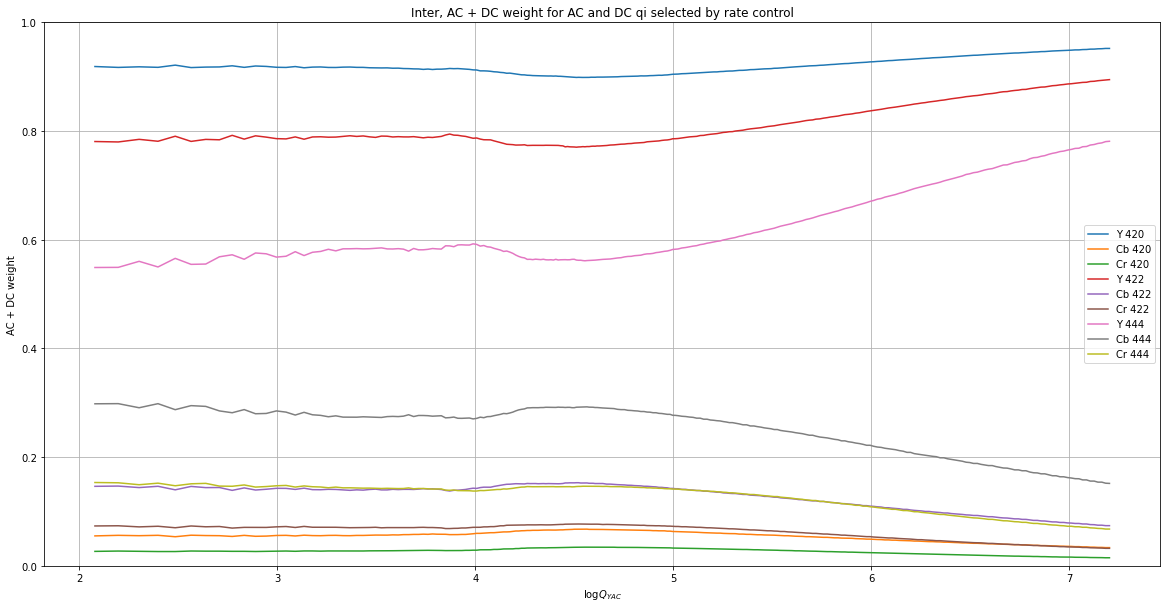

In [7]:
plt.figure(figsize=(20, 10))
    
for n, subsampling in enumerate(SUBSAMPLINGS):
    for plane in PLANES:
        xs, ys = [], []
        for base_qi in range(1, 240):
            qi_y_dc = q_to_qidx[subsampling][plane]['dc'][base_qi]
            qi_y_ac = q_to_qidx[subsampling][plane]['ac'][base_qi]

            weight_dc = mean_data[subsampling][plane]['dc'][qi_y_dc]
            weight_ac = mean_data[subsampling][plane]['ac'][qi_y_ac]

            xs.append(np.log(AC_LOOKUP_Q3[q_to_qidx[subsampling][0]['ac'][base_qi]]))
            ys.append(weight_dc + weight_ac)

        plt.plot(xs, ys, label=f'{PLANE_NAMES[plane]} {subsampling}')
    
plt.ylabel('AC + DC weight')
plt.xlabel('$\log Q_{Y AC}$')
plt.ylim(bottom=0, top=1)
plt.title(f'Inter, AC + DC weight for AC and DC qi selected by rate control')
plt.legend()
plt.grid()
        
# plt.savefig('public_html/inter-ac-plus-dc-weight-log-qyac.png', dpi=300, bbox_inches='tight')
plt.show()

Turns out, there *is* a good dependency hiding in the data.

Let's take each API quantization index, get the 6 quantizers and compute $\bar Q$ using our weight data. Let's then plot every quantizer against $\bar Q$ in log-space. Turns out, this dependency is very close to linear, which means we can set $\bar Q$ from the API quantization index and use the linear models to derive the 6 quantizers, instead of the current logic in the encoder.

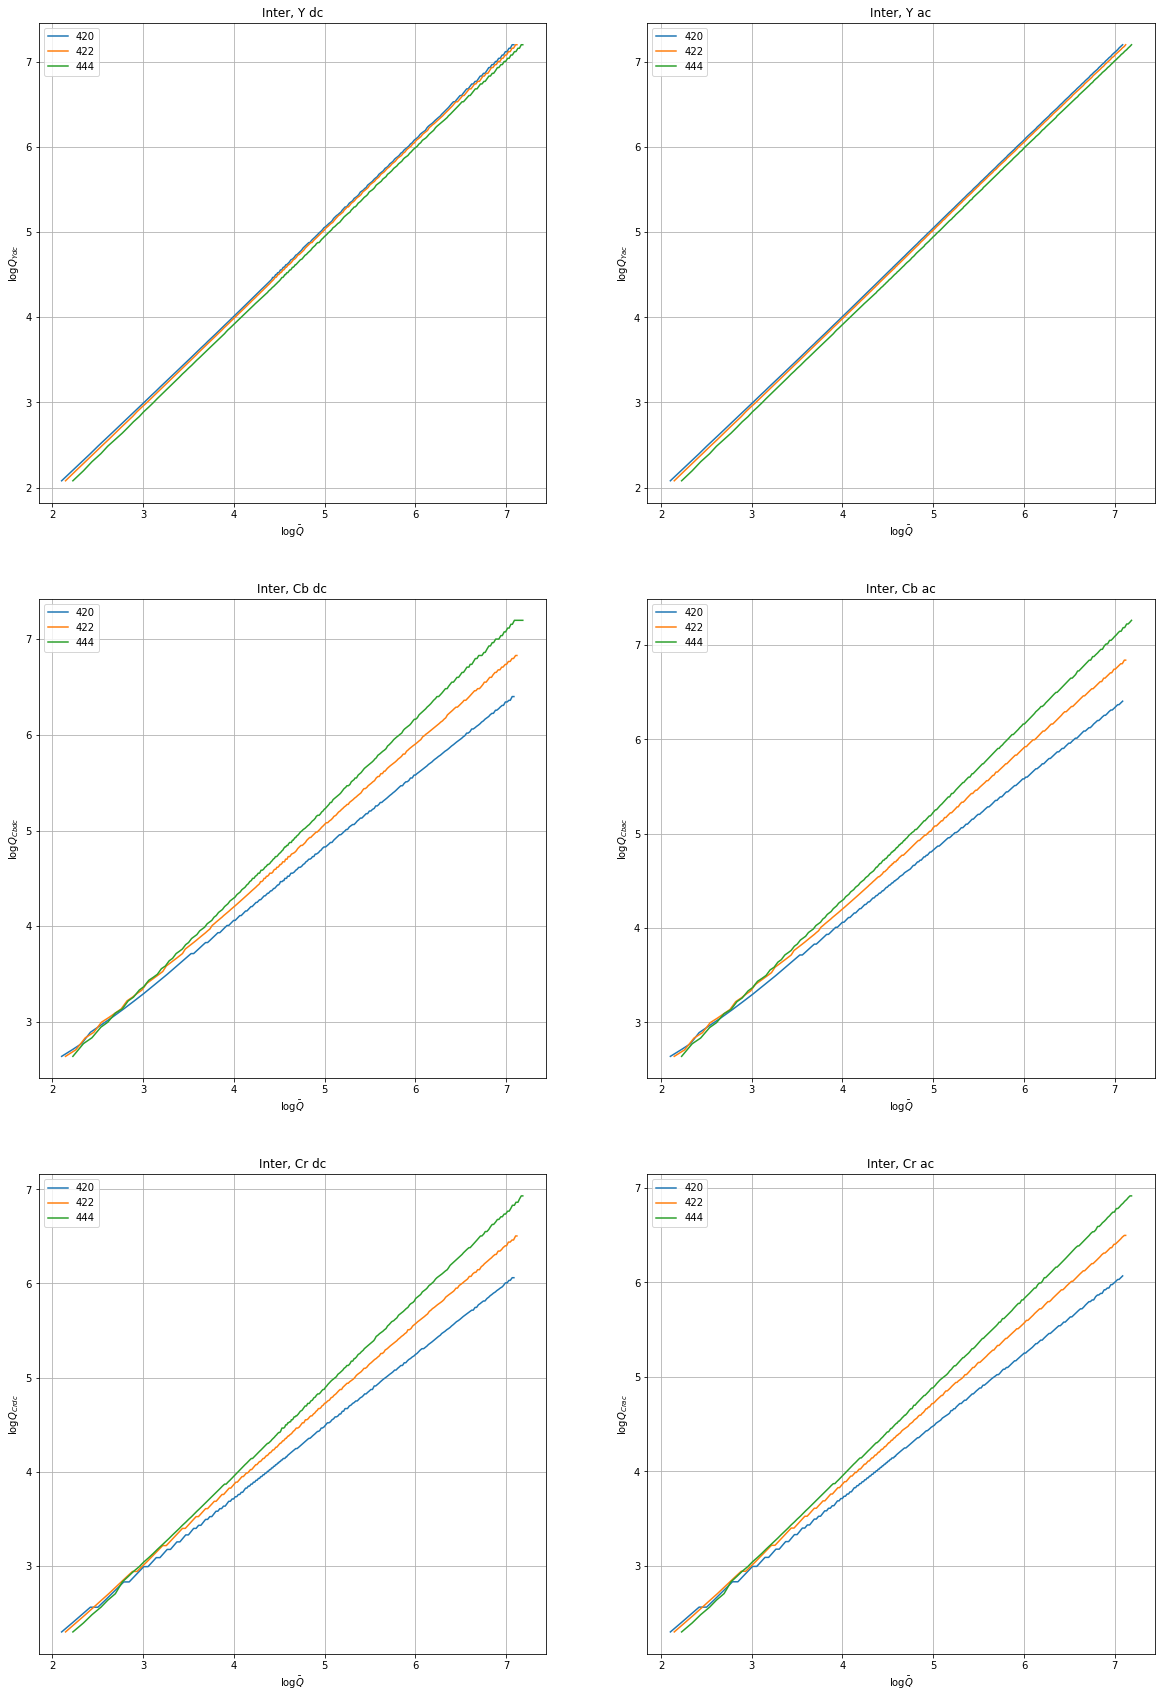

In [8]:
linear_models = {
    subsampling: {
        plane: {
            q_type: linear_model.LinearRegression()
            for q_type in Q_TYPES
        } for plane in PLANES
    } for subsampling in SUBSAMPLINGS
}

plt.figure(figsize=(20, 30))

for overall_plane in PLANES:
    for n, q_type in enumerate(Q_TYPES):
        plt.subplot(3, 2, overall_plane * 2 + n + 1)
        
        for subsampling in SUBSAMPLINGS:
            xs, ys = [], []
            for base_qi in range(1, 240):
                total = 0
                for plane in range(3):
                    qi_dc = q_to_qidx[subsampling][plane]['dc'][base_qi]
                    qi_ac = q_to_qidx[subsampling][plane]['ac'][base_qi]

                    weight_dc = mean_data[subsampling][plane]['dc'][qi_dc]
                    weight_ac = mean_data[subsampling][plane]['ac'][qi_ac]

                    q_dc = DC_LOOKUP_Q3[qi_dc]
                    q_ac = AC_LOOKUP_Q3[qi_ac]

                    total += weight_dc / (q_dc ** 2) + weight_ac / (q_ac ** 2)

                q_bar = np.sqrt(1 / total)

                xs.append(np.log(q_bar))
                ys.append(np.log(Q_TYPE_TO_LOOKUP[q_type][q_to_qidx[subsampling][overall_plane][q_type][base_qi]]))

            plt.plot(xs, ys, label=f'{subsampling}')
                
            X = np.array(xs).reshape(-1, 1)
            y = np.array(ys)
            linear_models[subsampling][overall_plane][q_type].fit(X, y)
            
#             plt.plot(xs, linear_models[subsampling][overall_plane][q_type].predict(X), linestyle='dashed', label=f'{subsampling} predicted')
    
        plt.xlabel('$\log \\bar Q$')
        plt.ylabel(f'$\log Q_{{{PLANE_NAMES[overall_plane]}{q_type}}}$')
        plt.title(f'Inter, {PLANE_NAMES[overall_plane]} {q_type}')
        plt.legend()
        plt.grid()
        
# plt.savefig('public_html/inter-q-bar-to-log-quantizers.png', dpi=300, bbox_inches='tight')
plt.show()

Output rav1e code from the trained linear models, such that:
$$
\ln Q_i = \ln \bar Q \cdot \text{Q_MODEL_MUL}_i + \text{Q_MODEL_ADD}_i.
$$

In [9]:
plane_names_rav1e = {
    0: 'y',
    1: 'u',
    2: 'v',
}

print('const Q_MODEL_ADD: [[[f64; 3]; 2]; 3] = [')

for subsampling in SUBSAMPLINGS:
    print('  //', ':'.join(subsampling))
    print('  [')
    for q_type in Q_TYPES:
        print('    //', q_type.upper())
        print(f'    [{", ".join([str(linear_models[subsampling][plane][q_type].intercept_) for plane in PLANES])}],')
    print('  ],')
print('];')

print('const Q_MODEL_MUL: [[[f64; 3]; 2]; 3] = [')

for subsampling in SUBSAMPLINGS:
    print('  //', ':'.join(subsampling))
    print('  [')
    for q_type in Q_TYPES:
        print('    //', q_type.upper())
        print(f'    [{", ".join([str(linear_models[subsampling][plane][q_type].coef_[0]) for plane in PLANES])}],')
    print('  ],')
print('];')

const Q_MODEL_ADD: [[[f64; 3]; 2]; 3] = [
  // 4:2:0
  [
    // DC
    [-0.11656242387547344, 1.0204689822943789, 0.6886094438200243],
    // AC
    [-0.11692591176935974, 1.0198189027518891, 0.6890266761982824],
  ],
  // 4:2:2
  [
    // DC
    [-0.14394892466839426, 0.8159473007572995, 0.47871627350291224],
    // AC
    [-0.1443099499314302, 0.8143304669365223, 0.47843462255605296],
  ],
  // 4:4:4
  [
    // DC
    [-0.22649962259502487, 0.5656726799733809, 0.22305586707855252],
    // AC
    [-0.22684363329351775, 0.5635050277164071, 0.22268207844634347],
  ],
];
const Q_MODEL_MUL: [[[f64; 3]; 2]; 3] = [
  // 4:2:0
  [
    // DC
    [1.0331807205305543, 0.7598630717649668, 0.7591572564919543],
    // AC
    [1.033087726384096, 0.7599926596666513, 0.7590002362509559],
  ],
  // 4:2:2
  [
    // DC
    [1.0332396344168826, 0.8475784581494014, 0.8476834789229545],
    // AC
    [1.0331466354360417, 0.8478359280824787, 0.8477755000169171],
  ],
  // 4:4:4
  [
    // DC
    [1.0349179

Rav1e already derives color plane quantizers from the Y quantizer based on a linear model:
$$
\log_2 Q_i = \log_2 Q_{\text{Y},\text{AC}} \cdot C + D,
$$
where for 4:2:0:
$$
C = \left[1, 1 - \left(\frac14 + \frac1{64}\right), 1 - \left(\frac14 + \frac1{64}\right), 1, 1 - \left(\frac14 + \frac1{64}\right), 1 - \left(\frac14 + \frac1{64}\right)\right],\\
D = \left[0, \log_2 7 - \log_2 4, \log_2 5 - \log_2 4, 0, \log_2 7 - \log_2 4, \log_2 5 - \log_2 4\right].
$$

Since both models are linear, we can use the learned model to derive $\log_2 Q_{\text{Y},\text{AC}}$ from $\log_2 \bar Q$ in such a way that applying the color plane model produces closest possible results to the learned model:
$$
\log_2 Q_{\text{Y},\text{AC}} = \left(\log_2 \bar Q \cdot A + B' - D\right) C^T \left(C C^T\right)^{-1} \\
 = \left(\log_2 \bar Q \cdot A + B' - D\right) C' \\
 = \log_2 \bar Q \cdot A C' + \left(B' - D\right) C',
$$
where $B' = \left(\left(A - 1\right)\cdot\text{QSCALE} + \frac B {\ln 2}\right)$ to convert the learned model to the space of rav1e quantizer calculations.

In [10]:
def project(subsampling):
    M = {
        '420': 1 / 4 + 1 / 64,
        '422': 1 / 8 + 1 / 16 - 1 / 128,
        '444': 1 / 16 + 1 / 32 + 1 / 256,
    }[subsampling]
    C = np.array([1, 1 - M, 1 - M] * 2)
    D = np.log2([4, 7, 5] * 2) - np.log2(4)

    A = np.array([
        linear_models[subsampling][0]['dc'].coef_[0],
        linear_models[subsampling][1]['dc'].coef_[0],
        linear_models[subsampling][2]['dc'].coef_[0],
        linear_models[subsampling][0]['ac'].coef_[0],
        linear_models[subsampling][1]['ac'].coef_[0],
        linear_models[subsampling][2]['ac'].coef_[0],
    ])
    B = np.array([
        linear_models[subsampling][0]['dc'].intercept_,
        linear_models[subsampling][1]['dc'].intercept_,
        linear_models[subsampling][2]['dc'].intercept_,
        linear_models[subsampling][0]['ac'].intercept_,
        linear_models[subsampling][1]['ac'].intercept_,
        linear_models[subsampling][2]['ac'].intercept_,
    ])
    QSCALE = 3
    B_ = (A - 1) * QSCALE + B / np.log(2)

    C_ = C.T / np.dot(C, C.T)
    
    return np.dot(A, C_), np.dot(B_ - D, C_)

coeffs = {subsampling: project(subsampling) for subsampling in SUBSAMPLINGS}

for subsampling, value in coeffs.items():
    print(f"{subsampling}: log_q_y = log_target_q * {value[0]} - {-value[1]}")

420: log_q_y = log_target_q * 1.0336962260323812 - 0.07092213406024961
422: log_q_y = log_target_q * 1.0333169937188251 - 0.10792428914875732
444: log_q_y = log_target_q * 1.0344948215612353 - 0.21975510266483608


Now, convert the values to a fixed-point integer form:

`log_q_y = log_target_q + (log_target_q >> 32) * MUL + ADD`

In [11]:
def hexify(n, q=57):
    if n < 0: return '-' + hexify(-n, q)
    return hex(np.round(n * (2 ** q)).astype(int))

print("const Q_MODEL_ADD: [i64; 3] = [")
for subsampling, value in coeffs.items():
    print(f"  // {':'.join(subsampling)}")
    print(f"  {hexify(value[1])},")
print("];")

print("const Q_MODEL_MUL: [i64; 3] = [")
for subsampling, value in coeffs.items():
    print(f"  // {':'.join(subsampling)}")
    print(f"  {hexify(value[0] - 1, q=32)},")
print("];")

const Q_MODEL_ADD: [i64; 3] = [
  // 4:2:0
  -0x244fe7ecb3dd90,
  // 4:2:2
  -0x3741da38ad0924,
  // 4:4:4
  -0x7083bda626311c,
];
const Q_MODEL_MUL: [i64; 3] = [
  // 4:2:0
  0x8a050dd,
  // 4:2:2
  0x8877666,
  // 4:4:4
  0x8d4a712,
];


Distortion scales should be set to $\left(\frac{\bar Q}{\bar Q_\text{plane}}\right)^2$, where
$$
\bar Q_\text{plane} = \sqrt{\frac{\sum_i^{\left\{\text{DC}, \text{AC}\right\}} N_{\text{plane},i} \sigma_{\text{plane},i}^2}{\sum_i^{\left\{\text{DC}, \text{AC}\right\}} \frac{N_{\text{plane},i} \sigma_{\text{plane},i}^2}{Q_{\text{plane},i}^2}}}.
$$
`process-vstats` outputs these per-plane weights in a separate JSON key (`plane_{q_type}_weights` instead of just `{q_type}_weights`). The averaging process is exactly the same as for overall weights.

In [12]:
mean_data_per_seq_plane = {
    sequence: {
        subsampling: {
            plane: {
                q_type: {} for q_type in Q_TYPES
            } for plane in PLANES
        } for subsampling in SUBSAMPLINGS
    } for sequence in SEQUENCES
}

for sequence in tqdm(SEQUENCES):
    for subsampling in SUBSAMPLINGS:
        with open(join(OUTPUT_DIR, f'{sequence}_{subsampling}_720p50.json'), 'r') as f:
            data = json.load(f)

        for plane in PLANES:
            for q_type in Q_TYPES:
                for qidx in range(256):
                    values = data['false'][str(plane)][f'plane_{q_type}_weights'][qidx]
                    if len(values) != 0:
                        mean_data_per_seq_plane[sequence][subsampling][plane][q_type][qidx] = np.mean(values)

mean_data_plane = {
    subsampling: {
        plane: {
            q_type: {} for q_type in Q_TYPES
        } for plane in PLANES
    } for subsampling in SUBSAMPLINGS
}

for subsampling in tqdm(SUBSAMPLINGS):
    for plane in PLANES:
        for q_type in Q_TYPES:
            for qidx in range(256):
                values = []
                for sequence in SEQUENCES:
                    data = mean_data_per_seq_plane[sequence][subsampling][plane][q_type]
                    if qidx in data:
                        values.append(data[qidx])

                if len(values) > 0:
                    mean_data_plane[subsampling][plane][q_type][qidx] = np.mean(values)

100%|██████████| 3/3 [00:00<00:00, 38.22it/s]


Plotting the AC per-plane weight reveals that the AC weight is very close to 1 for all quantizers. Thus, the decision was made to simply scale distortion with $\left(\frac{\bar Q}{Q_{\text{plane}, AC}}\right)^2$.

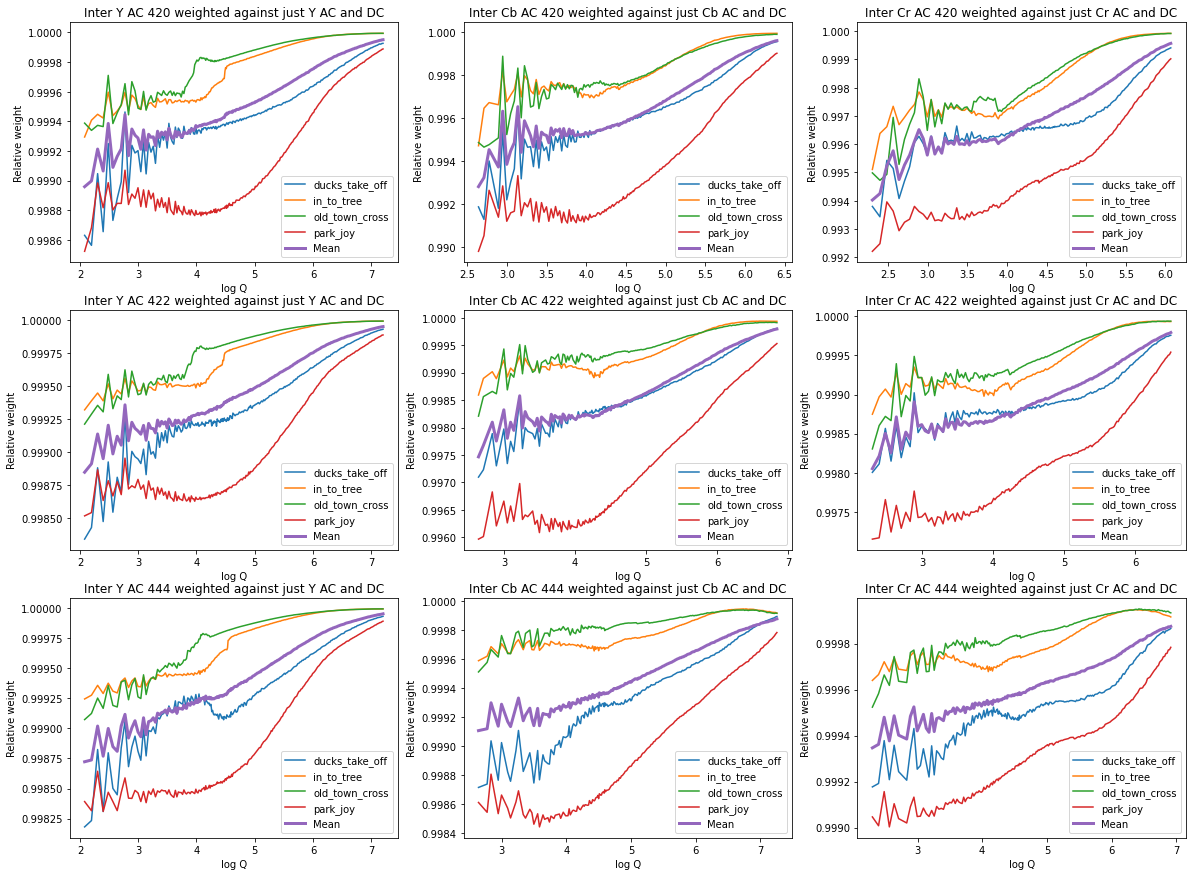

In [13]:
plt.figure(figsize=(20, 15))
    
for n, subsampling in enumerate(SUBSAMPLINGS):
    for plane in PLANES:
        plt.subplot(3, 3, n * 3 + plane + 1)

        for sequence in SEQUENCES:
            data = mean_data_per_seq_plane[sequence][subsampling][plane]['ac']
            qidxs, values = list(data.keys()), list(data.values())
            plt.plot(np.log(AC_LOOKUP_Q3[qidxs]), values, label=sequence)

        data = mean_data_plane[subsampling][plane]['ac']
        qidxs, values = list(data.keys()), list(data.values())
        plt.plot(np.log(AC_LOOKUP_Q3[qidxs]), values, label='Mean', linewidth=3)

        plt.ylabel('Relative weight')
        plt.xlabel('log Q')
        plt.legend(loc='lower right')
        plt.title(f'Inter {PLANE_NAMES[plane]} AC {subsampling} weighted against just {PLANE_NAMES[plane]} AC and DC')

# plt.savefig('public_html/inter-ac-just-acdc-log-q.png', dpi=300, bbox_inches='tight')
plt.show()

# Intra

We can repeat the same steps for intra frames.

However, testing showed that using the derived linear models lead to worse encoding results.

In [14]:
mean_data_per_seq = {
    sequence: {
        subsampling: {
            plane: {
                q_type: {} for q_type in Q_TYPES
            } for plane in PLANES
        } for subsampling in SUBSAMPLINGS
    } for sequence in SEQUENCES
}

for sequence in tqdm(SEQUENCES):
    for subsampling in SUBSAMPLINGS:
        with open(join(OUTPUT_DIR, f'{sequence}_{subsampling}_720p50.json'), 'r') as f:
            data = json.load(f)

        for plane in PLANES:
            for q_type in Q_TYPES:
                for qidx in range(256):
                    values = data['true'][str(plane)][f'{q_type}_weights'][qidx]
                    if len(values) != 0:
                        mean_data_per_seq[sequence][subsampling][plane][q_type][qidx] = np.mean(values)

mean_data = {
    subsampling: {
        plane: {
            q_type: {} for q_type in Q_TYPES
        } for plane in PLANES
    } for subsampling in SUBSAMPLINGS
}

for subsampling in tqdm(SUBSAMPLINGS):
    for plane in PLANES:
        for q_type in Q_TYPES:
            for qidx in range(256):
                values = []
                for sequence in SEQUENCES:
                    data = mean_data_per_seq[sequence][subsampling][plane][q_type]
                    if qidx in data:
                        values.append(data[qidx])

                if len(values) > 0:
                    mean_data[subsampling][plane][q_type][qidx] = np.mean(values)

100%|██████████| 3/3 [00:00<00:00, 39.36it/s]


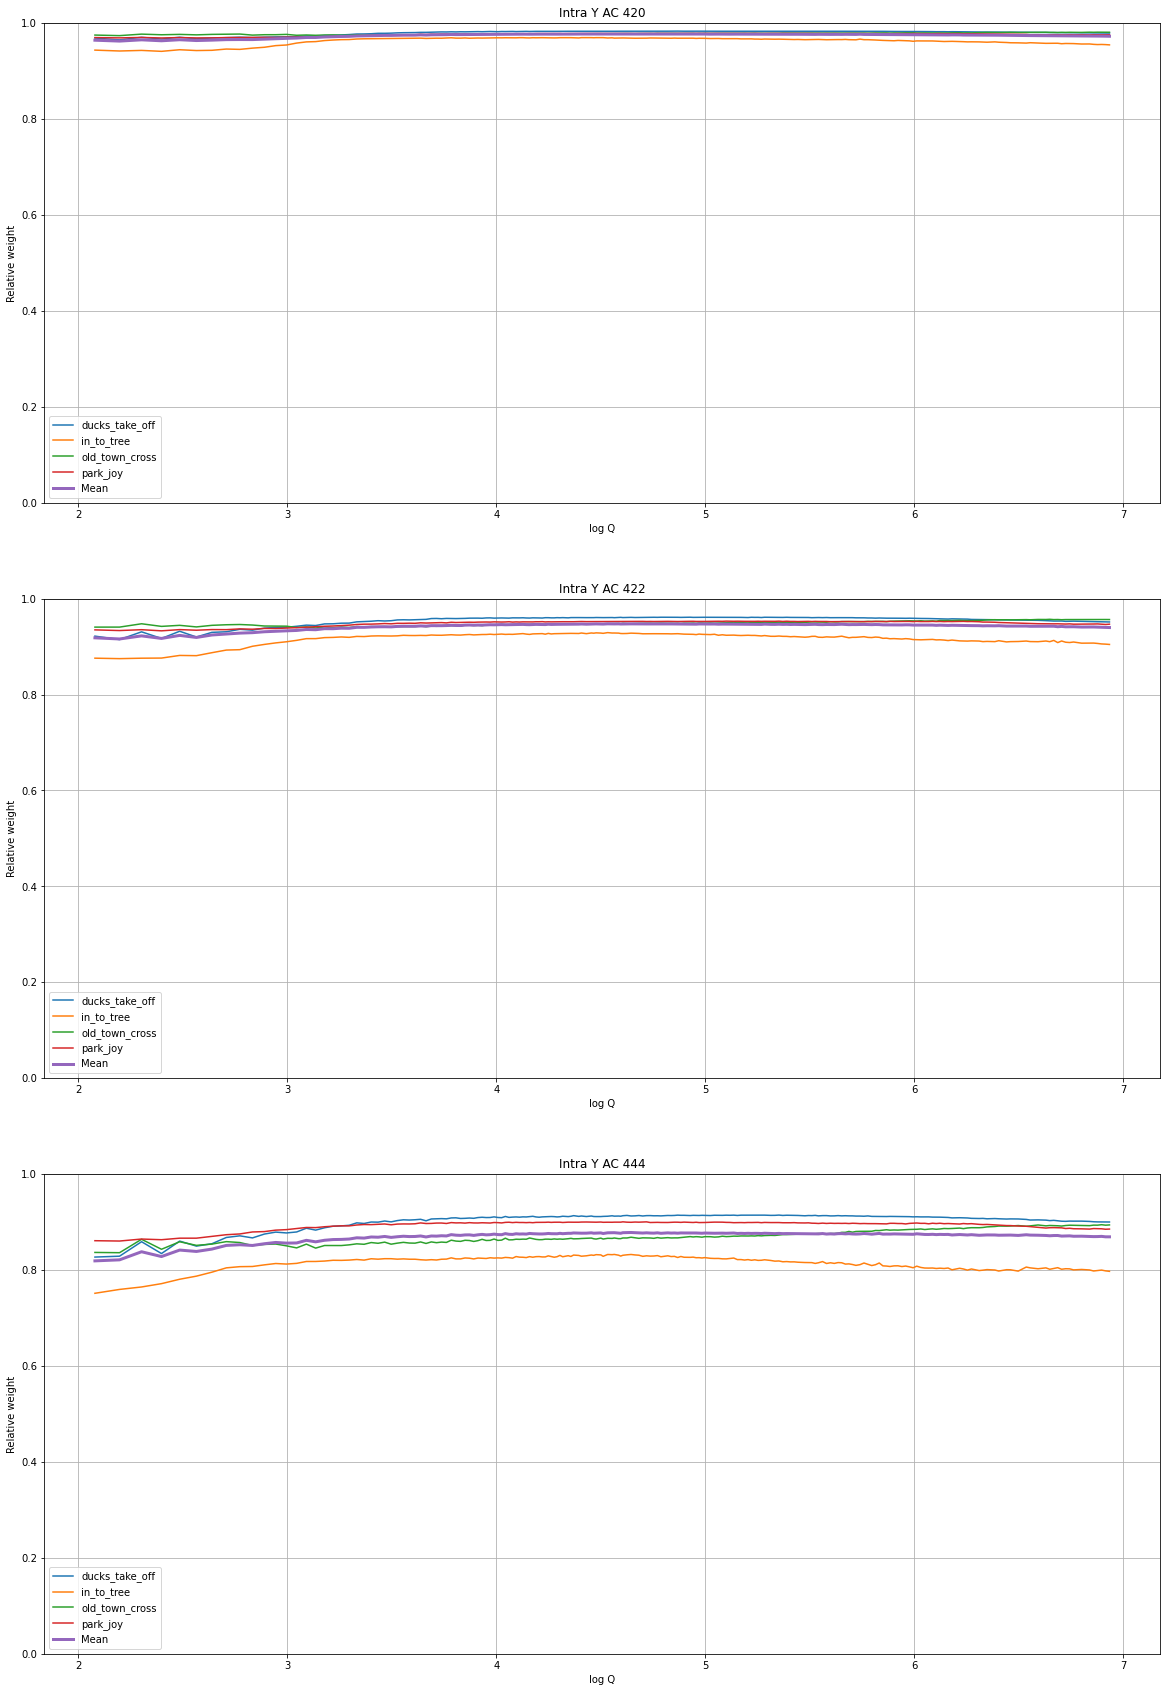

In [15]:
plt.figure(figsize=(20, 30))
    
for n, subsampling in enumerate(SUBSAMPLINGS):
    plt.subplot(3, 1, n + 1)

    for sequence in SEQUENCES:
        data = mean_data_per_seq[sequence][subsampling][0]['ac']
        qidxs, values = list(data.keys()), list(data.values())
        plt.plot(np.log(AC_LOOKUP_Q3[qidxs]), values, label=sequence)
        
    data = mean_data[subsampling][0]['ac']
    qidxs, values = list(data.keys()), list(data.values())
    plt.plot(np.log(AC_LOOKUP_Q3[qidxs]), values, label='Mean', linewidth=3)

    plt.ylabel('Relative weight')
    plt.xlabel('log Q')
    plt.ylim(bottom=0, top=1)
    plt.legend(loc='lower left')
    plt.grid()
    plt.title(f'Intra Y AC {subsampling}')

# plt.savefig('public_html/intra-y-ac-log-q.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
q_to_qidx = {
    subsampling: {
        plane: {
            q_type: {} for q_type in Q_TYPES
        } for plane in PLANES
    } for subsampling in SUBSAMPLINGS
}

for subsampling in SUBSAMPLINGS:
    for q in tqdm(range(1, 240)):
        got = {plane: False for plane in PLANES}
        
        with open(join(DATA_DIR, f'{SEQUENCES[0]}_{subsampling}_720p50-q{q}.log'), 'r') as f:
            for line in f:
                s = line.split()
                t = s[0]
                p = list(map(int, s[1:]))

                if t == 'f':
                    continue

                assert t == 'b'

                s1, s2, plane, pixel_count, dc_qidx, ac_qidx, block_is_intra, frame_is_intra = p

                if frame_is_intra == 0:
                    continue

                q_to_qidx[subsampling][plane]['dc'][q] = dc_qidx
                q_to_qidx[subsampling][plane]['ac'][q] = ac_qidx
                
                got[plane] = True
                if all([got[plane] for plane in PLANES]):
                    break

100%|██████████| 239/239 [00:00<00:00, 19948.63it/s]


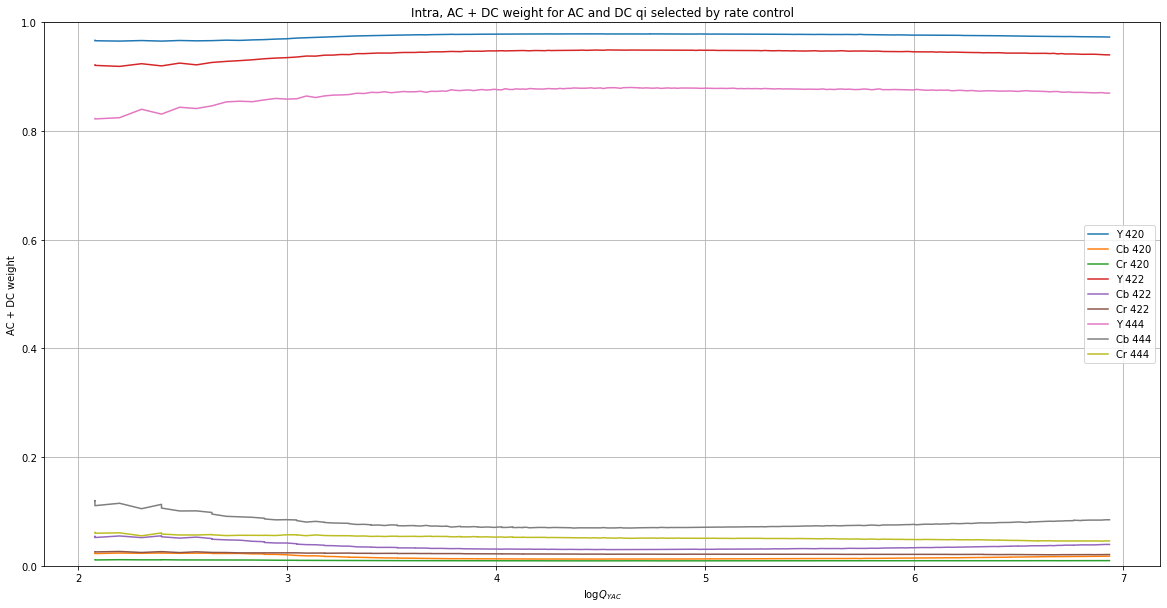

In [17]:
plt.figure(figsize=(20, 10))
    
for n, subsampling in enumerate(SUBSAMPLINGS):
    for plane in PLANES:
        xs, ys = [], []
        for base_qi in range(1, 240):
            qi_y_dc = q_to_qidx[subsampling][plane]['dc'][base_qi]
            qi_y_ac = q_to_qidx[subsampling][plane]['ac'][base_qi]

            weight_dc = mean_data[subsampling][plane]['dc'][qi_y_dc]
            weight_ac = mean_data[subsampling][plane]['ac'][qi_y_ac]

            xs.append(np.log(AC_LOOKUP_Q3[q_to_qidx[subsampling][0]['ac'][base_qi]]))
            ys.append(weight_dc + weight_ac)

        plt.plot(xs, ys, label=f'{PLANE_NAMES[plane]} {subsampling}')
    
plt.ylabel('AC + DC weight')
plt.xlabel('$\log Q_{Y AC}$')
plt.ylim(bottom=0, top=1)
plt.title(f'Intra, AC + DC weight for AC and DC qi selected by rate control')
plt.legend()
plt.grid()
        
# plt.savefig('public_html/intra-ac-plus-dc-weight-log-qyac.png', dpi=300, bbox_inches='tight')
plt.show()

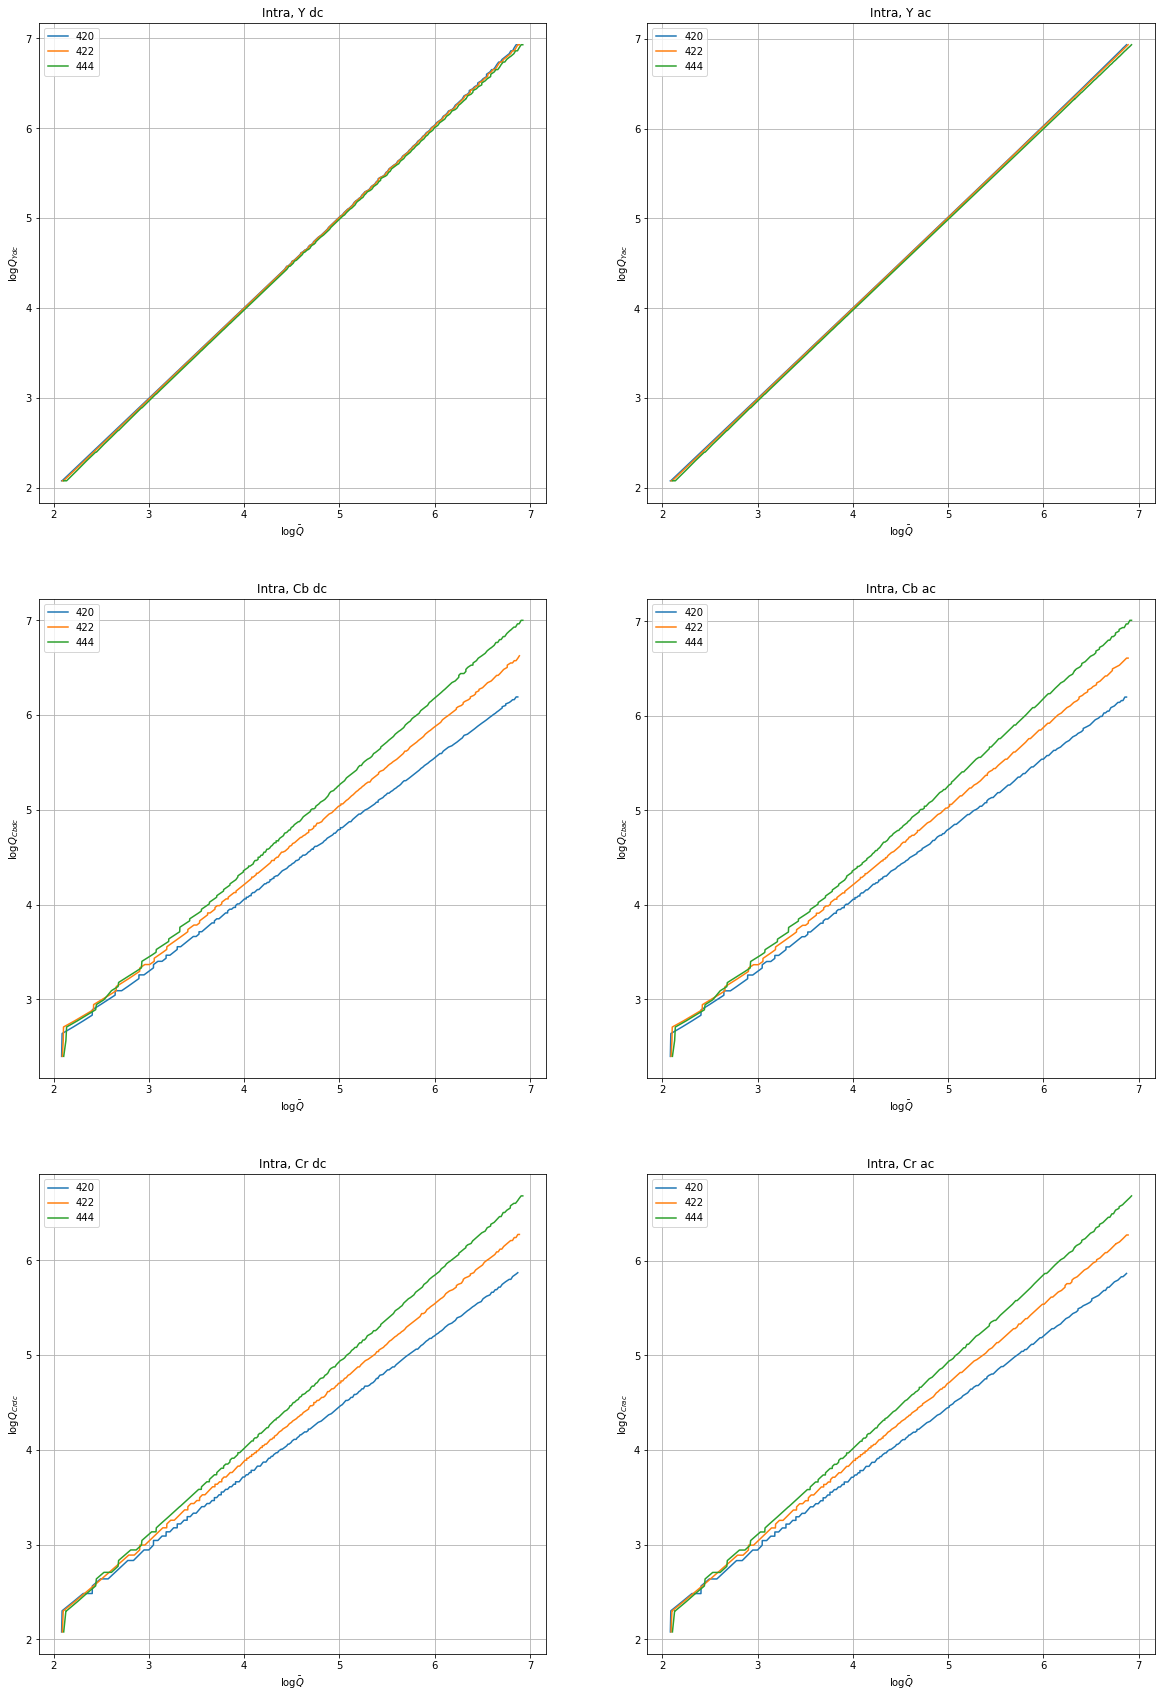

In [18]:
linear_models = {
    subsampling: {
        plane: {
            q_type: linear_model.LinearRegression()
            for q_type in Q_TYPES
        } for plane in PLANES
    } for subsampling in SUBSAMPLINGS
}

plt.figure(figsize=(20, 30))

for overall_plane in PLANES:
    for n, q_type in enumerate(Q_TYPES):
        plt.subplot(3, 2, overall_plane * 2 + n + 1)
        
        for subsampling in SUBSAMPLINGS:
            xs, ys = [], []
            for base_qi in range(1, 240):
                total = 0
                for plane in range(3):
                    qi_dc = q_to_qidx[subsampling][plane]['dc'][base_qi]
                    qi_ac = q_to_qidx[subsampling][plane]['ac'][base_qi]

                    weight_dc = mean_data[subsampling][plane]['dc'][qi_dc]
                    weight_ac = mean_data[subsampling][plane]['ac'][qi_ac]

                    q_dc = DC_LOOKUP_Q3[qi_dc]
                    q_ac = AC_LOOKUP_Q3[qi_ac]

                    total += weight_dc / (q_dc ** 2) + weight_ac / (q_ac ** 2)

                q_bar = np.sqrt(1 / total)

                xs.append(np.log(q_bar))
                ys.append(np.log(Q_TYPE_TO_LOOKUP[q_type][q_to_qidx[subsampling][overall_plane][q_type][base_qi]]))

            plt.plot(xs, ys, label=f'{subsampling}')
                
            X = np.array(xs).reshape(-1, 1)
            y = np.array(ys)
            linear_models[subsampling][overall_plane][q_type].fit(X, y)
            
#             plt.plot(xs, linear_models[subsampling][overall_plane][q_type].predict(X), linestyle='dashed', label=f'{subsampling} predicted')
    
        plt.xlabel('$\log \\bar Q$')
        plt.ylabel(f'$\log Q_{{{PLANE_NAMES[overall_plane]}{q_type}}}$')
        plt.title(f'Intra, {PLANE_NAMES[overall_plane]} {q_type}')
        plt.legend()
        plt.grid()
        
# plt.savefig('public_html/intra-q-bar-to-log-quantizers.png', dpi=300, bbox_inches='tight')
plt.show()

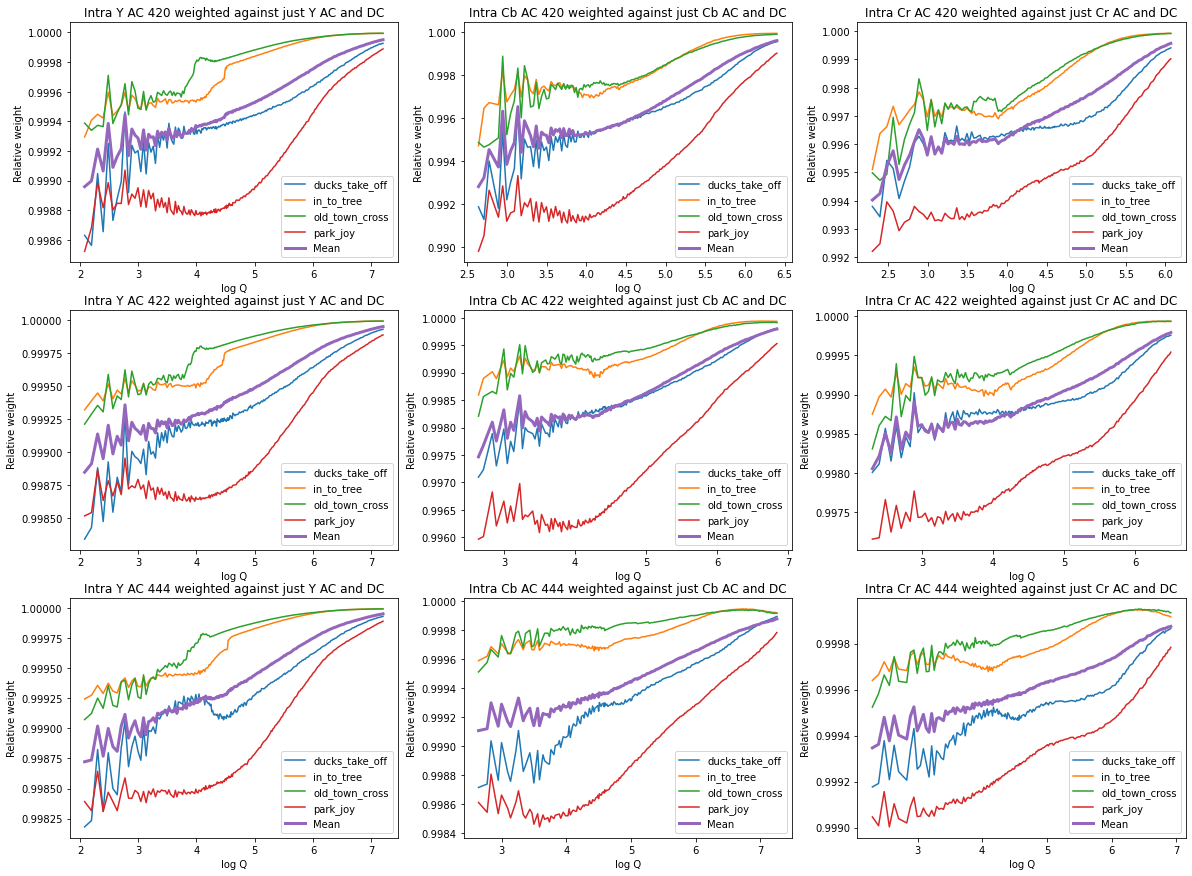

In [19]:
plt.figure(figsize=(20, 15))
    
for n, subsampling in enumerate(SUBSAMPLINGS):
    for plane in PLANES:
        plt.subplot(3, 3, n * 3 + plane + 1)

        for sequence in SEQUENCES:
            data = mean_data_per_seq_plane[sequence][subsampling][plane]['ac']
            qidxs, values = list(data.keys()), list(data.values())
            plt.plot(np.log(AC_LOOKUP_Q3[qidxs]), values, label=sequence)

        data = mean_data_plane[subsampling][plane]['ac']
        qidxs, values = list(data.keys()), list(data.values())
        plt.plot(np.log(AC_LOOKUP_Q3[qidxs]), values, label='Mean', linewidth=3)

        plt.ylabel('Relative weight')
        plt.xlabel('log Q')
        plt.legend(loc='lower right')
        plt.title(f'Intra {PLANE_NAMES[plane]} AC {subsampling} weighted against just {PLANE_NAMES[plane]} AC and DC')

# plt.savefig('public_html/intra-ac-just-acdc-log-q.png', dpi=300, bbox_inches='tight')
plt.show()